<a href="https://www.kaggle.com/code/utkarshx27/forecasting-mini-course-sales?scriptVersionId=137228577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, cross_val_score


train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


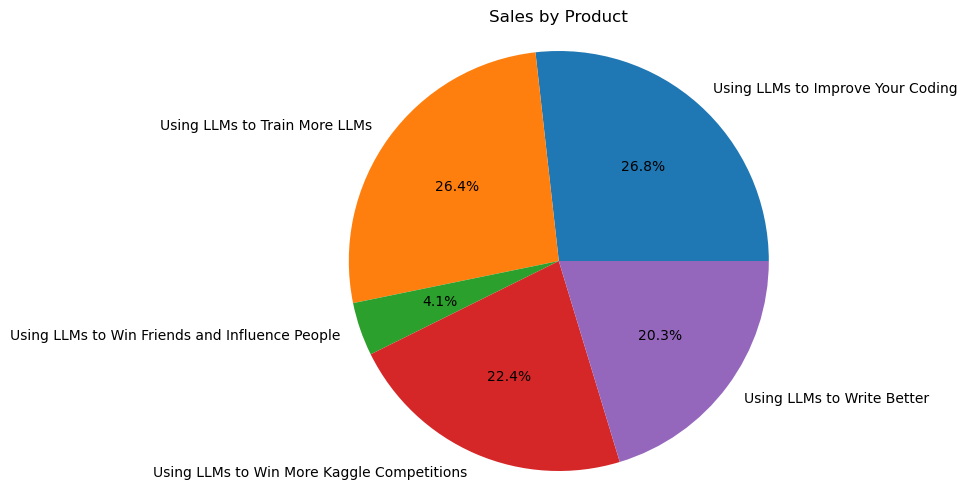

In [2]:
product_sales = train.groupby('product')['num_sold'].sum()
plt.figure(figsize=(8, 6))
plt.pie(product_sales.values, labels=product_sales.index, autopct='%1.1f%%')
plt.title('Sales by Product')
plt.axis('equal')
plt.show()

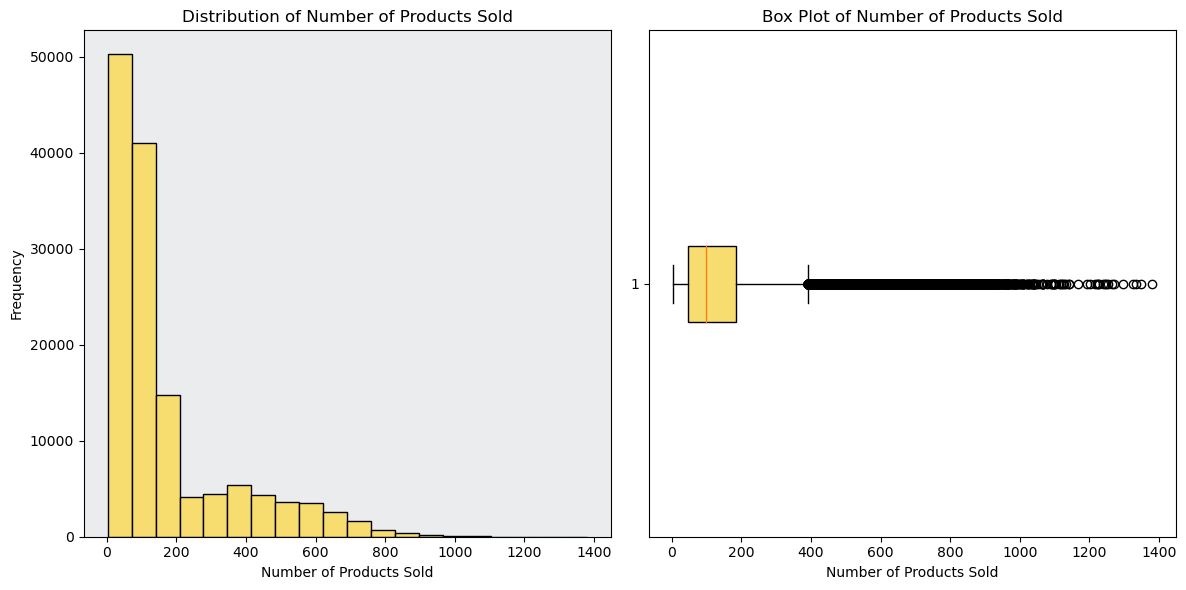

In [3]:
num_sold_data = train['num_sold']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(num_sold_data, bins=20, edgecolor='k', color='#F7DC6F')
axes[0].set_xlabel('Number of Products Sold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Number of Products Sold')
axes[0].set_facecolor('#EAECEE')

axes[1].boxplot(num_sold_data, vert=False, patch_artist=True, boxprops=dict(facecolor='#F7DC6F'))
axes[1].set_xlabel('Number of Products Sold')
axes[1].set_title('Box Plot of Number of Products Sold')
plt.tight_layout()
plt.show()

In [4]:
country_group = train.groupby('country').agg({'num_sold': ['sum', 'mean']})
store_group = train.groupby('store').agg({'num_sold': ['sum', 'mean']})
product_group = train.groupby('product').agg({'num_sold': ['sum', 'mean']})

print("Grouped by 'country':")
print(country_group)

print("\nGrouped by 'store':")
print(store_group)

print("\nGrouped by 'product':")
print(product_group)

Grouped by 'country':
          num_sold            
               sum        mean
country                       
Argentina  1683244   61.454691
Canada     7013114  256.046513
Estonia    3577319  130.606754
Japan      6013786  219.561373
Spain      4380862  159.943848

Grouped by 'store':
              num_sold            
                   sum        mean
store                             
Kagglazon     15661335  343.074151
Kaggle Learn   2755934   60.370953
Kaggle Store   4251056   93.122804

Grouped by 'product':
                                               num_sold            
                                                    sum        mean
product                                                            
Using LLMs to Improve Your Coding               6069281  221.587477
Using LLMs to Train More LLMs                   5993975  218.838080
Using LLMs to Win Friends and Influence People   932564   34.047609
Using LLMs to Win More Kaggle Competitions      5068313  185.042461


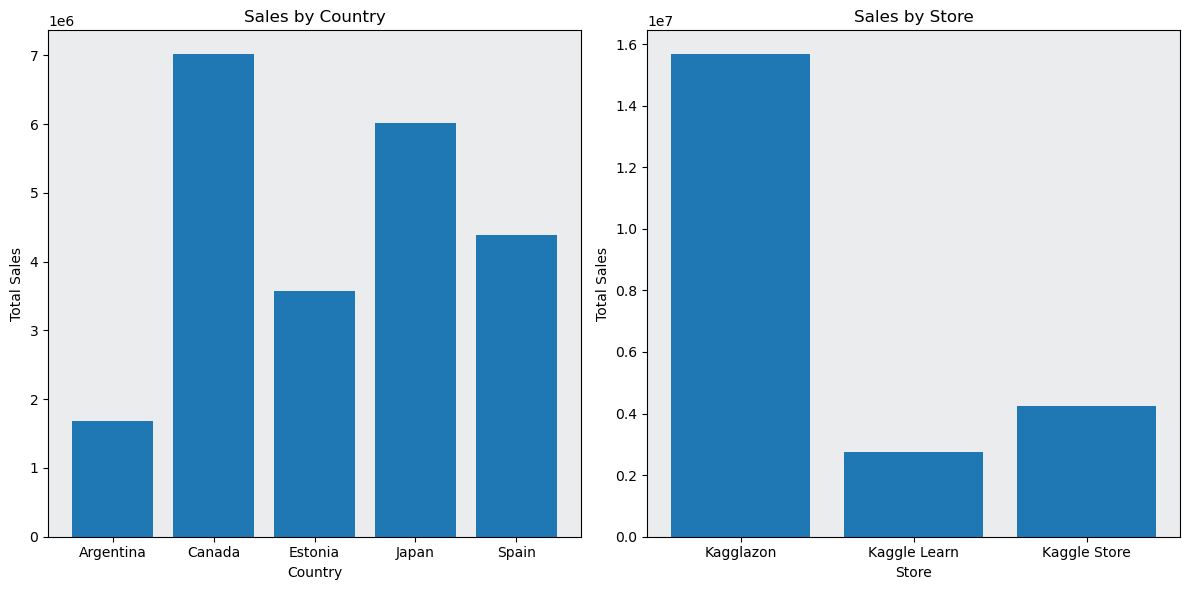

In [5]:
country_sales = train.groupby('country')['num_sold'].sum()
store_sales = train.groupby('store')['num_sold'].sum()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(country_sales.index, country_sales.values)
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('Sales by Country')
axes[0].set_facecolor('#EAECEE')

axes[1].bar(store_sales.index, store_sales.values)
axes[1].set_xlabel('Store')
axes[1].set_ylabel('Total Sales')
axes[1].set_title('Sales by Store')
axes[1].set_facecolor('#EAECEE')

plt.tight_layout()
plt.show()

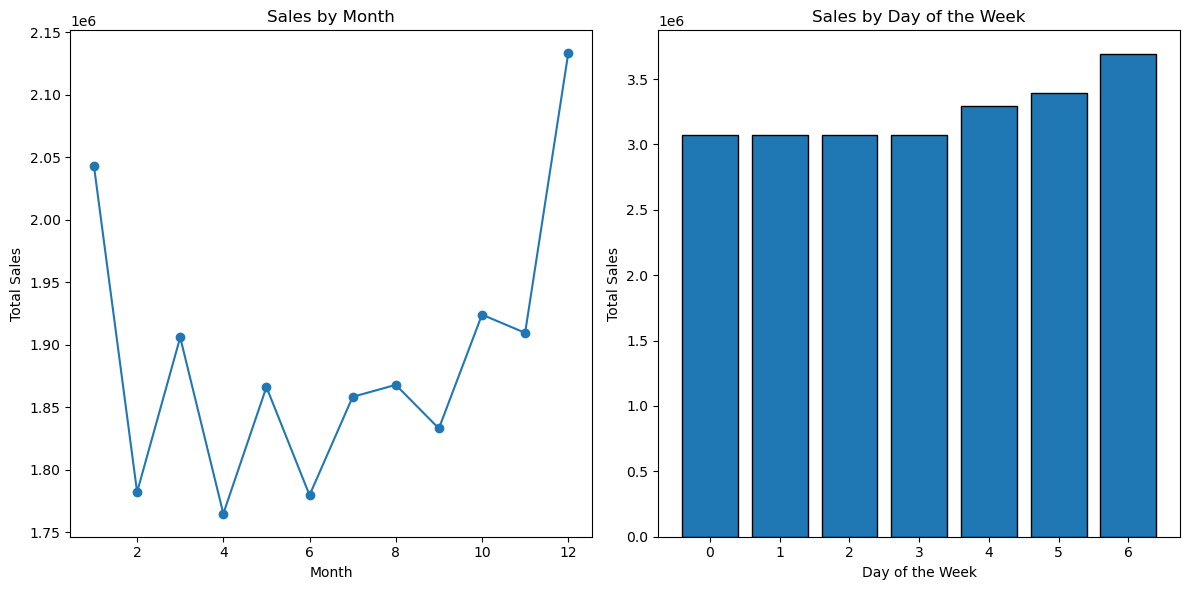

In [6]:
train_copy = train.copy()

train_copy['month'] = pd.to_datetime(train_copy['date']).dt.month
train_copy['day_of_week'] = pd.to_datetime(train_copy['date']).dt.dayofweek

monthly_sales = train_copy.groupby('month')['num_sold'].sum()
day_of_week_sales = train_copy.groupby('day_of_week')['num_sold'].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('Sales by Month')
axes[1].bar(day_of_week_sales.index, day_of_week_sales.values, edgecolor='k')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Total Sales')
axes[1].set_title('Sales by Day of the Week')
axes[1].set_xticks(range(7))

plt.tight_layout()
plt.show()

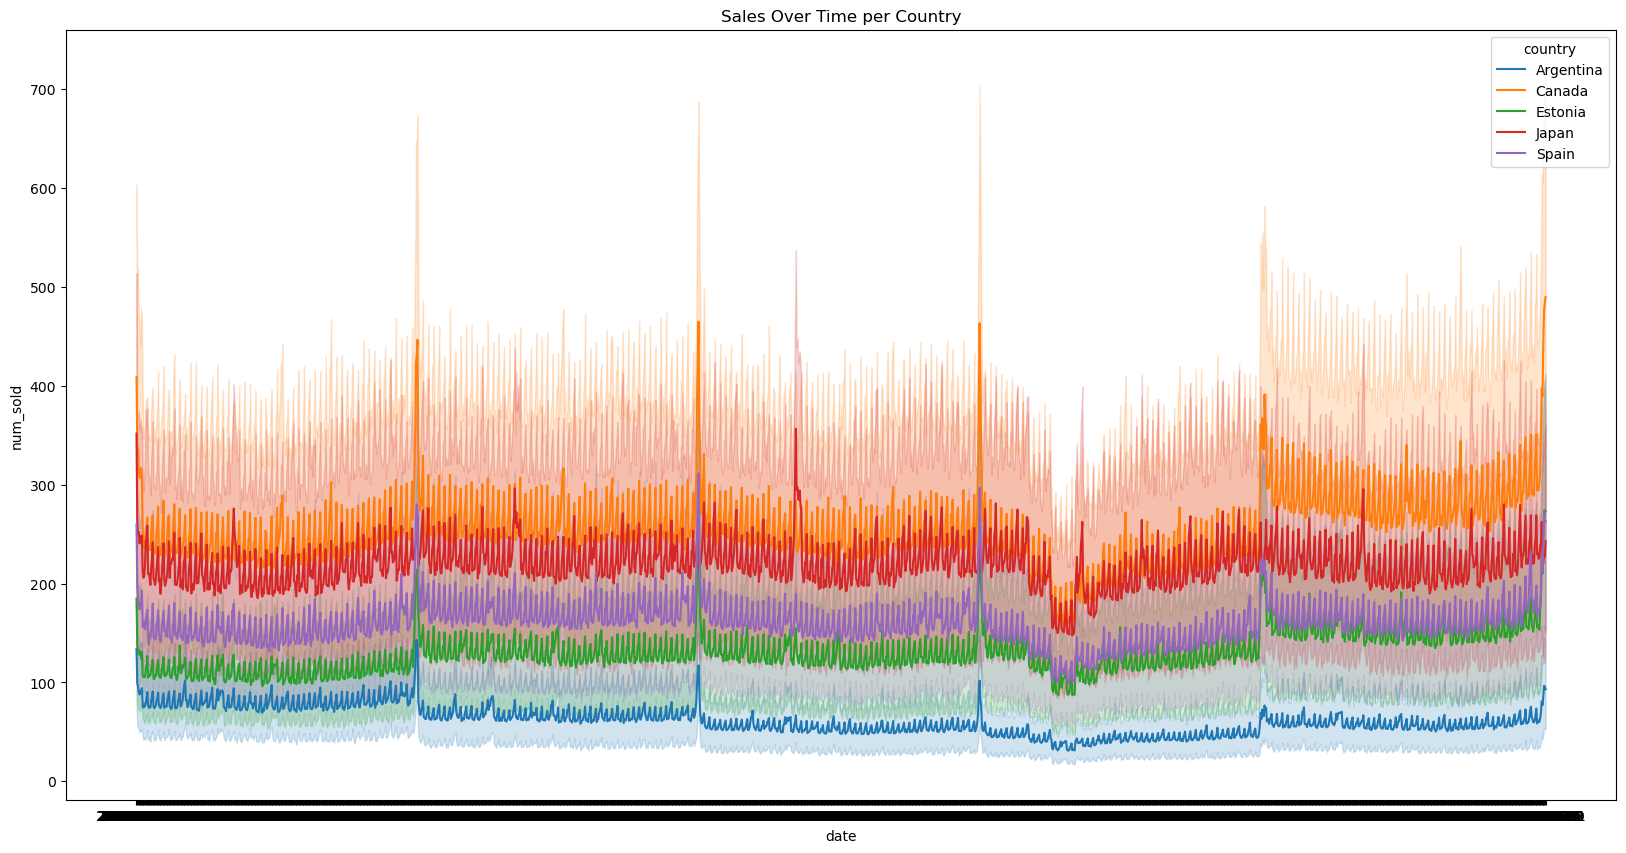

In [7]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = train_copy, x = 'date', y = 'num_sold', hue = 'country')    
plt.title('Sales Over Time per Country')
plt.show()

In [8]:
def process(df):
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_month'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    
    le = LabelEncoder()
    df['country'] = le.fit_transform(df['country'])
    df['store'] = le.fit_transform(df['store'])
    df['product'] = le.fit_transform(df['product'])
    
    return df

train = process(train)
test = process(test)

In [9]:
# scaler = StandardScaler()
# X = train.drop(['num_sold', 'id', 'date'], axis=1)
# X = scaler.fit_transform(X)
# y = train['num_sold']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
train['date'] = train['date'].astype(int) // 10**9

In [11]:
X = train.drop(['num_sold', 'id'], axis=1)
y = train['num_sold']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

base_models = [
    ('linear', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42))
]

meta_model = XGBRegressor(random_state=42)
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_regressor.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 237.74508073232317
R-squared Score: 0.9930010141269815


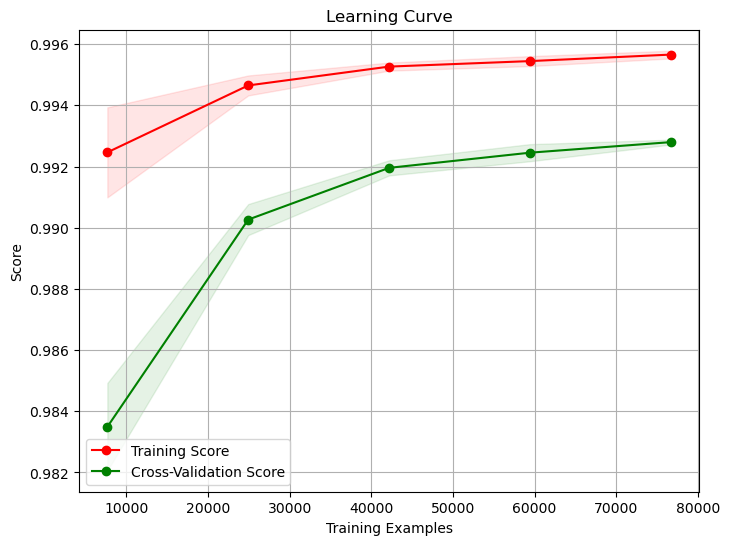

In [12]:
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')

    plt.show()

model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
plot_learning_curve(model, X_train, y_train, cv=5)

In [13]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
bias = 1 - np.mean(cv_scores)
variance = np.var(cv_scores)

print("Bias: ", bias)
print("Variance: ", variance)

Bias:  0.00720156025691665
Variance:  6.267567089843581e-09


In [14]:
test['date'] = test['date'].astype(int) // 10**9 
test = test.drop('id', axis=1)
preds = stacking_regressor.predict(test)

ids = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')['id']
submission = pd.DataFrame({
    'id': ids,
    'num_sold': preds,
})

submission.to_csv('submission_stacking.csv', index=False)